### Read in results YAML from metacoder and do some visualization

In [2]:
import yaml

results_yaml_file = "../results/mcp_literature_eval_results_20250917.yaml"
with open(results_yaml_file, 'r') as file:
    metacoder_results = yaml.safe_load(file)


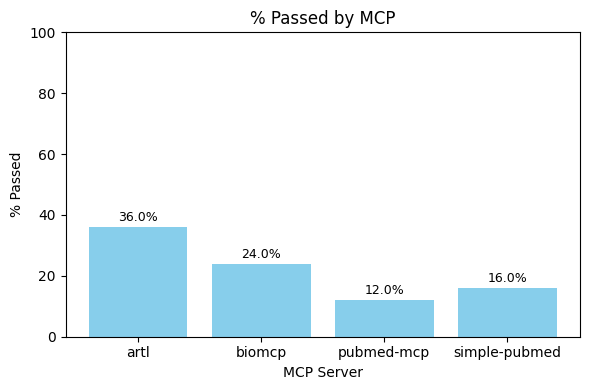

In [3]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt

# Load YAML
with open(results_yaml_file, 'r') as file:
    metacoder_results = yaml.safe_load(file)

# Convert YAML results to DataFrame
df = pd.DataFrame(metacoder_results['results'])

# Expand rows so each server gets its own row
df = df.explode('servers')

# Use the server as MCP identifier
df['MCP'] = df['servers']

# Calculate % passed for each MCP
percent_passed = (
    df.groupby('MCP')['passed']
    .mean()
    .reset_index()
)
percent_passed['percent_passed'] = percent_passed['passed'] * 100

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percent_passed['MCP'], percent_passed['percent_passed'], color='skyblue')
plt.ylabel('% Passed')
plt.xlabel('MCP Server')
plt.title('% Passed by MCP')
plt.ylim(0, 100)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


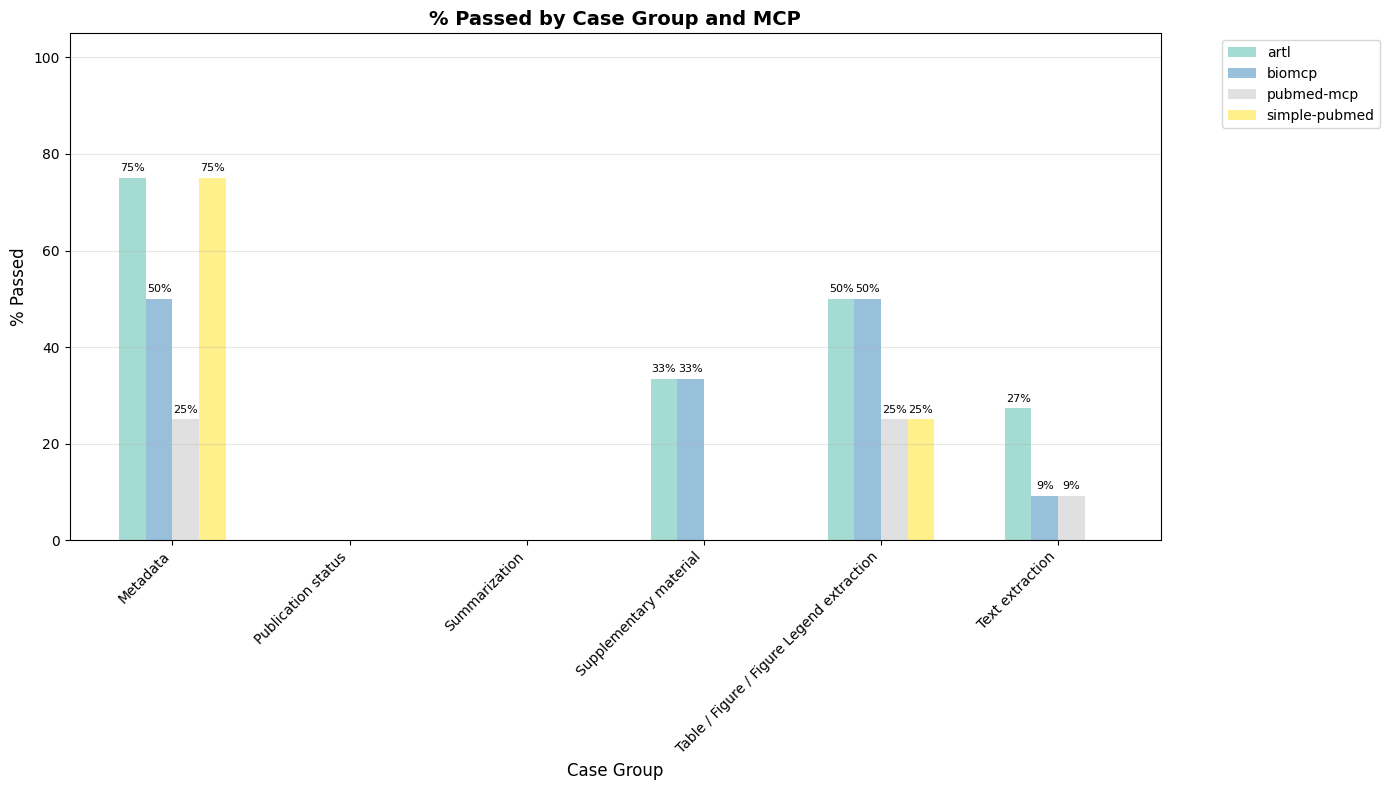


Summary Table: Cases Passed/Total by Case Group and MCP
MCP                                        artl biomcp pubmed-mcp  \
case_group                                                          
Metadata                                    3/4    2/4        1/4   
Publication status                          0/1    0/1        0/1   
Summarization                               0/2    0/2        0/2   
Supplementary material                      1/3    1/3        0/3   
Table / Figure / Figure Legend extraction   2/4    2/4        1/4   
Text extraction                            3/11   1/11       1/11   

MCP                                       simple-pubmed  
case_group                                               
Metadata                                            3/4  
Publication status                                  0/1  
Summarization                                       0/2  
Supplementary material                              0/3  
Table / Figure / Figure Legend extraction 

In [4]:
# Grouped bar plot: % passed by case_group for each MCP
import numpy as np

# Calculate % passed by case_group and MCP
grouped_stats = (
    df.groupby(['case_group', 'MCP'])['passed']
    .mean()
    .reset_index()
)
grouped_stats['percent_passed'] = grouped_stats['passed'] * 100

# Calculate counts (passed/total) by case_group and MCP
count_stats = (
    df.groupby(['case_group', 'MCP'])
    .agg({'passed': ['sum', 'count']})
    .reset_index()
)
count_stats.columns = ['case_group', 'MCP', 'passed_count', 'total_count']
count_stats['case_ratio'] = count_stats['passed_count'].astype(str) + '/' + count_stats['total_count'].astype(str)

# Pivot to get MCPs as columns and case_groups as rows
pivot_data = grouped_stats.pivot(index='case_group', columns='MCP', values='percent_passed')
pivot_data = pivot_data.fillna(0)  # Fill missing combinations with 0

# Pivot count data for the summary table
pivot_counts = count_stats.pivot(index='case_group', columns='MCP', values='case_ratio')
pivot_counts = pivot_counts.fillna('0/0')  # Fill missing combinations

# Create grouped bar plot
fig, ax = plt.subplots(figsize=(14, 8))

# Number of groups and bars
n_groups = len(pivot_data.index)
n_bars = len(pivot_data.columns)
bar_width = 0.15
index = np.arange(n_groups)

# Colors for each MCP
colors = plt.cm.Set3(np.linspace(0, 1, n_bars))

# Create bars for each MCP
for i, (mcp, color) in enumerate(zip(pivot_data.columns, colors)):
    bars = ax.bar(index + i * bar_width, pivot_data[mcp], bar_width,
                  label=mcp, color=color, alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        if height > 0:  # Only show label if there's a value
            ax.text(bar.get_x() + bar.get_width()/2, height + 1,
                   f'{height:.0f}%', ha='center', va='bottom', fontsize=8)

# Customize the plot
ax.set_xlabel('Case Group', fontsize=12)
ax.set_ylabel('% Passed', fontsize=12)
ax.set_title('% Passed by Case Group and MCP', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width * (n_bars - 1) / 2)
ax.set_xticklabels(pivot_data.index, rotation=45, ha='right')
ax.set_ylim(0, 105)  # Leave room for labels
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary table with counts (passed/total)
print("\nSummary Table: Cases Passed/Total by Case Group and MCP")
print("=" * 70)
print(pivot_counts)

In [ ]:
# Grouped scatter plot: Individual scores by case_group for each MCP
# Filled markers = passed, hollow markers = failed
import numpy as np
from matplotlib.lines import Line2D

# Create grouped scatter plot
fig, ax = plt.subplots(figsize=(14, 8))

# Get unique case groups and MCPs
case_groups = df['case_group'].unique()
mcps = df['MCP'].unique()

# Number of groups and scatter points
n_groups = len(case_groups)
n_mcps = len(mcps)
scatter_width = 0.15
index = np.arange(n_groups)

# Colors for each MCP (same as bar plot for consistency)
colors = plt.cm.Set3(np.linspace(0, 1, n_mcps))

# Create scatter points for each MCP
for i, (mcp, color) in enumerate(zip(mcps, colors)):
    mcp_data = df[df['MCP'] == mcp]
    
    for j, case_group in enumerate(case_groups):
        case_data = mcp_data[mcp_data['case_group'] == case_group]
        
        if len(case_data) > 0:
            # Calculate x position for this MCP within this case group
            base_x = j + i * scatter_width
            
            # Add some random jitter to avoid overlapping points
            x_positions = np.random.normal(base_x, 0.02, len(case_data))
            y_values = case_data['score']
            passed_values = case_data['passed']
            
            # Plot passed cases (filled markers)
            passed_mask = passed_values
            if passed_mask.any():
                ax.scatter(x_positions[passed_mask], y_values[passed_mask], 
                          color=color, alpha=0.8, s=60, edgecolors='black', linewidth=0.5)
            
            # Plot failed cases (hollow markers)
            failed_mask = ~passed_values
            if failed_mask.any():
                ax.scatter(x_positions[failed_mask], y_values[failed_mask], 
                          facecolors='none', edgecolors=color, alpha=0.8, s=60, linewidth=1.5)

# Customize the plot
ax.set_xlabel('Case Group', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Individual Scores by Case Group and MCP', fontsize=14, fontweight='bold')
ax.set_xticks(index + scatter_width * (n_mcps - 1) / 2)
ax.set_xticklabels(case_groups, rotation=45, ha='right')
ax.set_ylim(-0.05, 1.05)  # Scores are typically 0-1
ax.grid(axis='y', alpha=0.3)

# Create first legend for MCPs (colors)
mcp_legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                             markersize=8, markeredgecolor='black', label=mcp)
                      for mcp, color in zip(mcps, colors)]
mcp_legend = ax.legend(handles=mcp_legend_elements, title='MCP Servers', 
                      bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Create second legend for pass/fail symbols
status_legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', 
           markersize=8, markeredgecolor='black', label='Passed'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markersize=8, markeredgecolor='gray', markeredgewidth=1.5, label='Failed')
]
status_legend = ax.legend(handles=status_legend_elements, title='Test Result', 
                         bbox_to_anchor=(1.05, 0.7), loc='upper left', fontsize=9)

# Add the first legend back (matplotlib removes it when creating the second)
ax.add_artist(mcp_legend)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics: Score Distribution by Case Group and MCP")
print("=" * 70)
summary_stats = df.groupby(['case_group', 'MCP'])['score'].agg(['count', 'mean', 'std', 'min', 'max']).round(3)
print(summary_stats)

# Print pass/fail counts
print("\nPass/Fail Counts by Case Group and MCP")
print("=" * 50)
pass_fail_stats = df.groupby(['case_group', 'MCP'])['passed'].agg(['sum', 'count']).round(3)
pass_fail_stats.columns = ['passed_count', 'total_count']
pass_fail_stats['failed_count'] = pass_fail_stats['total_count'] - pass_fail_stats['passed_count']
print(pass_fail_stats[['passed_count', 'failed_count', 'total_count']])